<a href="https://colab.research.google.com/github/tycho-bro-hey/fixed-point-LWE/blob/main/_TFHE_Walktrhough.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INTRODUCTION
The purpose of this repository (and notebook) is for me to understand the theory and implementation of the fully homomorphic encryption over the torus (TFHE) scheme.  

We will be following section-by-section the [Fully Homomorphic Encryption from Scratch](https://www.daniellowengrub.com/blog/2024/01/03/fully-homomorphic-encryption#the-gsw-encryption-scheme).

# LEARNING WITH ERRORS
I am already quite familiar with the learning with errors (LWE) problem.  It as often attributed to Regev and [his 2009 paper](https://cims.nyu.edu/~regev/papers/qcrypto.pdf). From my dissertation, I have written the following:

The learning with errors (LWE) problem, including its decisional version, are foundational problems in lattice-based cryptography.  The LWE problem, which was introduced by Regev, involves solving for a secret vector given a set of noisy linear equations, which is considered the search version. The search version states that due to the added noise (error), it is computationally hard to solve for an exact solution of the secret vector.  For the decisional variant, the goal is to distinguish between two distributions: one consisting of noisy linear equations generated from a secret vector and another consisting of random, uniformly distributed values. The formal definitions for these problems are:



*   Let $A \in \mathbb{Z}_q^{m\times n}$ be a randomly sampled matrix with uniform entries from $\mathbb{Z}_q$, $s \in \mathbb{Z}_q^n$ be a secrete vector chosen uniformly at random, and $e \in \mathbb{Z}_q^n$ be an error vector with entries drawn independently from the discrete error distribution $\chi$.  The search LWE problem is to recover the secret vector $s$ give the following system of equations: $b = As + e$ where $A$ is a public matrix and $b \in \mathbb{Z}_q^m$ is the noisy linear encoding of $s$.  As such, the problems states: Given polynomially many such samples $(A,b)$, the goal is to compute the secret vector $s$.
*   The decisional variant of the LWE problem defines an LWE distribution as a sequence of pairs $(A,b)$ where each pair is generated in the same fashion as the search variant. The decisional variant includes a uniform distribution that consists of a sequence of pairs $(\hat{A},\hat{b})$ where $\hat{a} \in \mathbb{Z}_q^n$ is chosen uniformly at random and $\hat{b} \in \mathbb{Z}_q$ is chosen uniformly at random, independent of $\hat{A}$. The decisional problem asks to distinguish between these two distributions with non-negligible probability.

As Regev demonstrated, solving the LWE problem is as hard as the worst-case lattice problems.  This established a strong connection between the average-case complexity of the LWE problem and the worst-case complexity of the SVP, implying that the underlying lattice problems are hard even for quantum computers.  Building on this foundation, our research leverages the hardness of the LWE assumption to build a public-key encryption (PKE) scheme that is secure against both classical and quantum adversaries, while also incorporating homomorphic properties to allow computations on encrypted data.

In [ ]:
import numpy as np
from typing import Optional

# 32-bit signed integer bounds
INT32_MIN = np.iinfo(np.int32).min
INT32_MAX = np.iinfo(np.int32).max

def uniform_sample_int32(size: int) -> np.ndarray:
    return np.random.randint(
        low=INT32_MIN,
        high=INT32_MAX + 1,
        size=size,
        dtype=np.int32,
    )

def gaussian_sample_int32(std: float, size: Optional[int]) -> np.int32:
    return np.int32(INT32_MAX * np.random.normal(loc=0.0, scale=std, size=size))


In [ ]:
import numpy as np
import dataclasses

@dataclasses.dataclass
class LweConfig:
    dimension: int
    noise_std: float

@dataclasses.dataclass
class LwePlaintext:
    message: np.int32

@dataclasses.dataclass
class LweCiphertext:
    config: LweConfig
    a: np.ndarray
    b: np.int32

@dataclasses.dataclass
class LweEncryptionKey:
    config: LweConfig
    key: np.ndarray

def generate_lwe_key(config: LweConfig) -> LweEncryptionKey:
    return LweEncryptionKey(
        config=config,
        key=np.random.randint(
            low=0, high=2, size=(config.dimension,), dtype=np.int32
        ),
    )

def lwe_encrypt(
    plaintext: LwePlaintext, key: LweEncryptionKey
) -> LweCiphertext:
    a = uniform_sample_int32(size=key.config.dimension)
    noise = gaussian_sample_int32(std=key.config.noise_std, size=None)

    b = np.add(np.dot(a, key.key), plaintext.message, dtype=np.int32)
    b = np.add(b, noise, dtype=np.int32)

    return LweCiphertext(config=key.config, a=a, b=b)

def lwe_decrypt(
    ciphertext: LweCiphertext, key: LweEncryptionKey
) -> LwePlaintext:
    return LwePlaintext(
        np.subtract(ciphertext.b, np.dot(ciphertext.a, key.key), dtype=np.int32)
    )


In [ ]:
# Configuration
LWE_CONFIG = LweConfig(dimension=1024, noise_std=2 ** (-24))

# Generate key
key = generate_lwe_key(LWE_CONFIG)

# Create a test message (2^29 to match future encoding)
plaintext = LwePlaintext(message=np.int32(2**29))

# Encrypt
ciphertext = lwe_encrypt(plaintext, key)

# Decrypt
decrypted = lwe_decrypt(ciphertext, key)

# Display results
print("Original message:", plaintext.message)
print("Decrypted message:", decrypted.message)
print("Error (should be small):", decrypted.message - plaintext.message)


Original message: 536870912
Decrypted message: 536870889
Error (should be small): -23


Mean error: -6.707
Max error: 409
Min error: -356


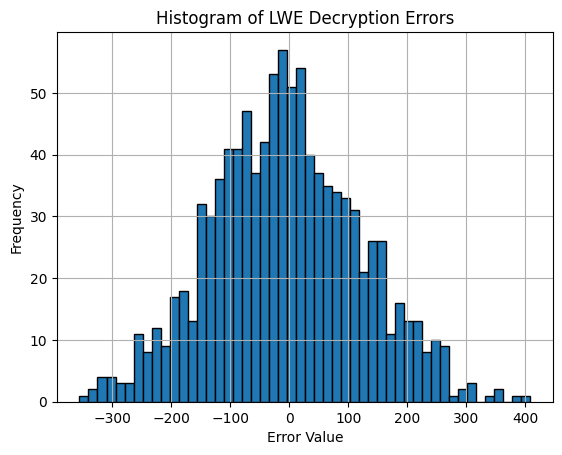

In [ ]:
# Generate an LWE key
key = generate_lwe_key(LWE_CONFIG)

# This is the plaintext that we will encrypt
plaintext = LwePlaintext(np.int32(2**29))

# Encrypt the plaintext 1000 times and store the error of each ciphertext.
errors = []
for _ in range(1000):
    ciphertext = lwe_encrypt(plaintext, key)
    decrypted = lwe_decrypt(ciphertext, key)
    error = decrypted.message - plaintext.message
    errors.append(error)

# Show basic stats
print(f"Mean error: {np.mean(errors)}")
print(f"Max error: {np.max(errors)}")
print(f"Min error: {np.min(errors)}")

import matplotlib.pyplot as plt

plt.hist(errors, bins=50, edgecolor='black')
plt.title("Histogram of LWE Decryption Errors")
plt.xlabel("Error Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


# Message Encoding

In the Python tutorial, the author mentions that the deciphering algorithm produces the original message plus some small error that was injected due to the LWE framework.  

I am going to deviate away from the tutorial to dive into some of what I have written in my dissertation.  My notation may deviate a bit from the tutorial, but the theory remains the same.

$LWE{(pk,m)} := \left(\mathcal{c}_1,\mathcal{c}_2\right) = \left(rA, r\nu + \left\lfloor\frac{q}{t}\right\rfloor m\right)$

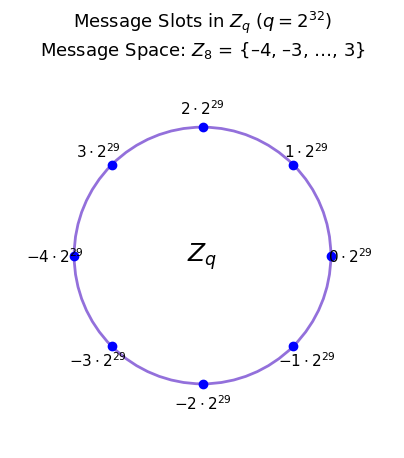

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
message_space_size = 2**3             # Number of message slots
Delta_exp = 32 - 3                     # q = 2^32, t = 2^3, q/t = 2^29
Delta = 2**Delta_exp
half = message_space_size // 2     # For symmetric range like [-4, ..., 3]

# Message points: [-half, ..., half - 1]
points = np.arange(-half, half)
labels = [rf"${i} \cdot 2^{{{Delta_exp}}}$" for i in points]
angles = np.linspace(-np.pi, np.pi, len(points), endpoint=False)


fig, ax = plt.subplots(figsize=(5, 5))
ax.set_aspect('equal')
circle = plt.Circle((0, 0), 1.0, color='mediumpurple', fill=False, linewidth=2)
ax.add_artist(circle)

# plot each point and its label
for angle, label in zip(angles, labels):
    x = np.cos(angle)
    y = np.sin(angle)
    ax.plot(x, y, 'bo')  # Blue dot
    ax.text(1.15 * x, 1.15 * y, label, ha='center', va='center', fontsize=11)

ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.axis('off')


ax.text(0, 0, r"$Z_q$", ha='center', va='center', fontsize=18)
plt.title(r"Message Slots in $Z_q$ ($q = 2^{32}$)" + "\n" + "Message Space: $Z_8$ = {–4, –3, …, 3}", fontsize=13)
plt.show()


Thus, for my research, we lift (or encode) our real-valued signals into a fixed-point message space.

In [ ]:
def encode(i: int) -> np.int32:
    """Encode an integer in [-4, 4) as an int32"""
    return np.multiply(i, 1 << 29, dtype=np.int32)

def decode(i: np.int32) -> int:
    """Decode an int32 to an integer in the range [-4, 4) mod 8"""
    d = int(np.rint(i / (1 << 29)))
    return ((d + 4) % 8) - 4

### FIXED-POINT DISSERTATION ENCODING ###

def encode_real_to_fixed(m: float, frac_bits: int) -> int:
    return int(np.round(m * (1 << frac_bits)))

def decode_fixed_to_real(m_fixed: int, frac_bits: int) -> float:
    return m_fixed / (1 << frac_bits)

#########################################

def lwe_encode(i: int) -> LwePlaintext:
    return LwePlaintext(encode(i))

def lwe_decode(plaintext: LwePlaintext) -> int:
    return decode(plaintext.message)

In [ ]:
# Generate LWE key
key = generate_lwe_key(LWE_CONFIG)

# Integer message in Z_8
original = 2

# Encode integer 2 → 2 * \Delta = 2 * 2^29
plaintext = lwe_encode(original)

# LWE Encrypt
ciphertext = lwe_encrypt(plaintext, key)

# Decrypt (returns noisy version of 2 * \Delta)
decrypted = lwe_decrypt(ciphertext, key)

# Decode (round and map to Z_8)
decoded = lwe_decode(decrypted)

# Print all internal steps
print(f"Original integer message (Z_8):         {original}")
print(f"Encoded plaintext message (int32):      {plaintext.message}")
print(f"Ciphertext component 'a' (vector):      {ciphertext.a[:5]}...")
print(f"Ciphertext component 'b' (int32):       {ciphertext.b}")
print(f"Decrypted (noisy fixed int):            {decrypted.message}")
print(f"Decoded message after decryption:       {decoded}")

# Verify correctness
assert decoded == original


Original integer message (Z_8):         2
Encoded plaintext message (int32):      1073741824
Ciphertext component 'a' (vector):      [-994504565 2040213410 -766869656  364008309  302292418]...
Ciphertext component 'b' (int32):       -1139442351
Decrypted (noisy fixed int):            1073741772
Decoded message after decryption:       2


In [ ]:
# Fixed-Point Encoding/Decoding Approach
FRAC_BITS = 16  # 16-bit fractional fixed-point

# Real-valued message
real_value = 3.14159

# Fixed-point encode the real value
fixed_encoded = encode_real_to_fixed(real_value, FRAC_BITS)

# Wrap into LWE plaintext using lwe_encode()
plaintext = LwePlaintext(np.int32(fixed_encoded))

# SEncrypt the encoded integer
ciphertext = lwe_encrypt(plaintext, key)

# Decrypt the ciphertext (returns noisy fixed-point integer)
decrypted = lwe_decrypt(ciphertext, key)

# Decode fixed-point back to real value
real_decoded = decode_fixed_to_real(decrypted.message, FRAC_BITS)

# Display result
print(f"Original real value:    {real_value}")
print(f"Fixed-point encoded:    {fixed_encoded}")
print(f"Decrypted fixed-point:  {decrypted.message}")
print(f"Decoded real value:     {real_decoded}")


Original real value:    3.14159
Fixed-point encoded:    205887
Decrypted fixed-point:  205783
Decoded real value:     3.1399993896484375
